In [1]:
"""
Movie Review Sentiment Analyzer
IMDb Movie Reviews Classification
"""

# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Downloading required NLTK data
print("Downloading NLTK resources...")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')  
print(" All libraries imported successfully!\n")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Gungun\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


 All libraries imported successfully!



STEP 1: LOADING AND EXPLORING THE DATASET
 Dataset loaded successfully!
 Dataset shape: (50000, 2)

 Dataset Information:
Columns: ['review', 'sentiment']
First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

 Data Quality Check:
Missing values:
review       0
sentiment    0
dtype: int64

 Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


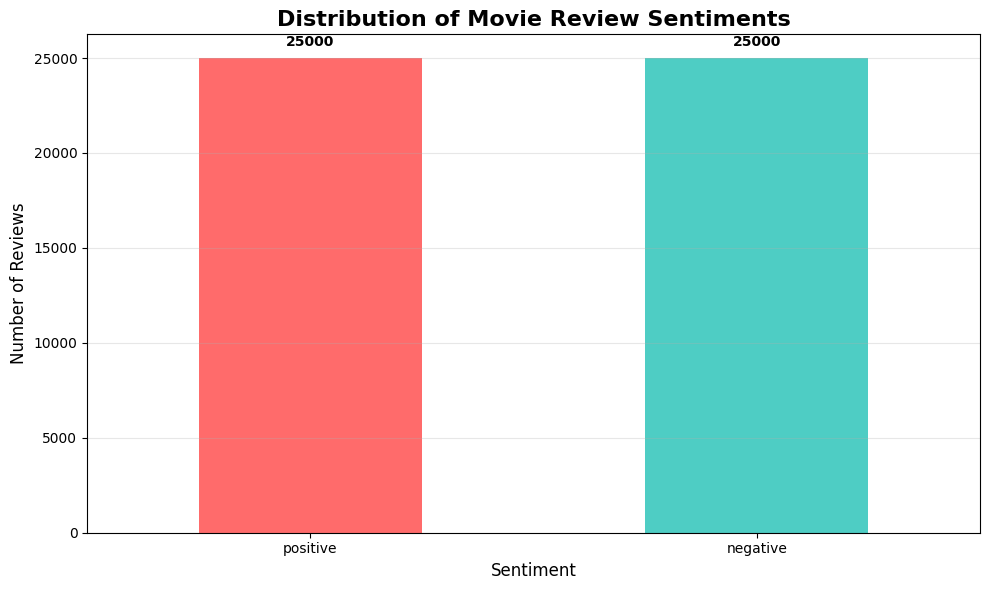

In [3]:
# Loading and Exploring the Dataset
print("=" * 60)
print("STEP 1: LOADING AND EXPLORING THE DATASET")
print("=" * 60)

# Load the dataset
file_path = "C:\\Users\\Gungun\\OneDrive\\Desktop\\data science\\IMDB Dataset.csv"
df = pd.read_csv(file_path)

print(f" Dataset loaded successfully!")
print(f" Dataset shape: {df.shape}")

# Display basic information
print("\n Dataset Information:")
print(f"Columns: {df.columns.tolist()}")
print(f"First few rows:")
print(df.head())

# Checking for missing values
print("\n Data Quality Check:")
print("Missing values:")
print(df.isnull().sum())

# Checking sentiment distribution
print("\n Sentiment Distribution:")
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

# Visualizing sentiment distribution
plt.figure(figsize=(10, 6))
colors = ['#ff6b6b', '#4ecdc4']
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Movie Review Sentiments', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 500, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [5]:
# Text Preprocessing 
print("\n" + "=" * 60)
print("STEP 2: TEXT PREPROCESSING")
print("=" * 60)

class TextPreprocessor:
    """
    Handles text preprocessing including tokenization, stopword removal, and lemmatization
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        
    def clean_text(self, text):
        """Clean and preprocess a single text review"""
        if not isinstance(text, str) or pd.isna(text):
            return ""
        
        # Step 1: Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Step 2: Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Step 3: Convert to lowercase
        text = text.lower()
        
        # Step 4: SIMPLE Tokenization (split by spaces instead of word_tokenize)
        tokens = text.split()
        
        # Step 5: Remove stopwords and short words
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        
        # Step 6: Lemmatization
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        
        return ' '.join(tokens)

# Initialize preprocessor
preprocessor = TextPreprocessor()

print(" Starting text preprocessing...")
print("This may take a few minutes for 50,000 reviews...")

# Apply preprocessing to first 1000 reviews for testing (then we'll do full dataset)
print("Processing first 1000 reviews for testing...")
df_sample = df.head(1000).copy()
df_sample['cleaned_review'] = df_sample['review'].apply(preprocessor.clean_text)

# Remove empty reviews after preprocessing
initial_count = len(df_sample)
df_sample = df_sample[df_sample['cleaned_review'].str.len() > 20]
final_count = len(df_sample)

print(f" Preprocessing completed!")
print(f" Original reviews: {initial_count}")
print(f" After cleaning: {final_count}")

# Show preprocessing examples
print("\n Preprocessing Examples:")
sample_reviews = df_sample.head(2)
for idx, row in sample_reviews.iterrows():
    print(f"\n--- Review {idx + 1} ---")
    print("ORIGINAL (first 150 chars):")
    print(row['review'][:150] + "...")
    print("\nCLEANED (first 150 chars):")
    print(row['cleaned_review'][:150] + "...")
    print(f"SENTIMENT: {row['sentiment']}")
    print("-" * 80)

# Now process the full dataset
print("\n Processing full dataset...")
df['cleaned_review'] = df['review'].apply(preprocessor.clean_text)

# Remove empty reviews
df = df[df['cleaned_review'].str.len() > 20]
print(f" Full dataset processing completed!")
print(f" Final dataset size: {len(df)}")


STEP 2: TEXT PREPROCESSING
 Starting text preprocessing...
This may take a few minutes for 50,000 reviews...
Processing first 1000 reviews for testing...
 Preprocessing completed!
 Original reviews: 1000
 After cleaning: 1000

 Preprocessing Examples:

--- Review 1 ---
ORIGINAL (first 150 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with...

CLEANED (first 150 chars):
one reviewer mentioned watching episode hooked right exactly happened first thing struck brutality unflinching scene violence set right word trust sho...
SENTIMENT: positive
--------------------------------------------------------------------------------

--- Review 2 ---
ORIGINAL (first 150 chars):
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes d...

CLEANED (first 150 chars):
wonderful little production filming 

In [6]:
# Preparing Data for Training
print("\n" + "=" * 60)
print("STEP 3: PREPARING DATA FOR TRAINING")
print("=" * 60)

# Prepare features (X) and labels (y)
X = df['cleaned_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})

print(" Dataset Summary:")
print(f"Total reviews: {len(X)}")
print(f"Positive reviews: {(y == 1).sum()}") 
print(f"Negative reviews: {(y == 0).sum()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Training-Test Split:")
print(f"Training set: {X_train.shape[0]} reviews")
print(f"Testing set: {X_test.shape[0]} reviews")


STEP 3: PREPARING DATA FOR TRAINING
 Dataset Summary:
Total reviews: 49999
Positive reviews: 25000
Negative reviews: 24999

 Training-Test Split:
Training set: 39999 reviews
Testing set: 10000 reviews


In [7]:
# TF-IDF Vectorization
print("\n" + "=" * 60)
print("STEP 4: TF-IDF VECTORIZATION")
print("=" * 60)

print(" Converting text to TF-IDF vectors...")

# Creating TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

# Fitting and transforming the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transforming the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF vectorization completed!")
print(f" Training features shape: {X_train_tfidf.shape}")
print(f" Testing features shape: {X_test_tfidf.shape}")


STEP 4: TF-IDF VECTORIZATION
 Converting text to TF-IDF vectors...
TF-IDF vectorization completed!
 Training features shape: (39999, 5000)
 Testing features shape: (10000, 5000)


In [11]:
# Model Training and Evaluation (CORRECTED)
print("\n" + "=" * 60)
print("STEP 5: MODEL TRAINING AND EVALUATION")
print("=" * 60)

class SentimentAnalyzer:
    """Trains and evaluates sentiment classification models"""
    
    def __init__(self):
        self.models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        self.results = {}
    
    def train_models(self, X_train, X_test, y_train, y_test):
        """Train both models and evaluate performance"""
        
        print(" Training Naive Bayes and Logistic Regression models...\n")
        
        for model_name, model in self.models.items():
            print(f" {model_name}")
            print("-" * 50)
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate evaluation metrics - FIXED: was y_test, y_test for recall
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)  # Fixed: was y_test, y_test
            f1 = f1_score(y_test, y_pred)
            
            # Store results
            self.results[model_name] = {
                'model': model,
                'predictions': y_pred,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1  # Fixed: consistent naming
            }
            
            # Print results
            print(f" Accuracy:  {accuracy:.4f}")
            print(f" Precision: {precision:.4f}")
            print(f" Recall:    {recall:.4f}")
            print(f" F1-Score:  {f1:.4f}")
            
            # Detailed classification report
            print(f"\n Classification Report:")
            print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
            print("=" * 50)
        
        return self.results
    
    def create_confusion_matrix(self, y_true, y_pred, model_name):
        """Create and display confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        return cm

# Initializing and training the sentiment analyzer
analyzer = SentimentAnalyzer()
results = analyzer.train_models(X_train_tfidf, X_test_tfidf, y_train, y_test)
           


STEP 5: MODEL TRAINING AND EVALUATION
 Training Naive Bayes and Logistic Regression models...

 Naive Bayes
--------------------------------------------------
 Accuracy:  0.8560
 Precision: 0.8426
 Recall:    0.8756
 F1-Score:  0.8588

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      5000
    Positive       0.84      0.88      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

 Logistic Regression
--------------------------------------------------
 Accuracy:  0.8850
 Precision: 0.8747
 Recall:    0.8988
 F1-Score:  0.8866

 Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.87      0.88      5000
    Positive       0.87      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.


STEP 6: CONFUSION MATRIX VISUALIZATION

 Naive Bayes Confusion Matrix


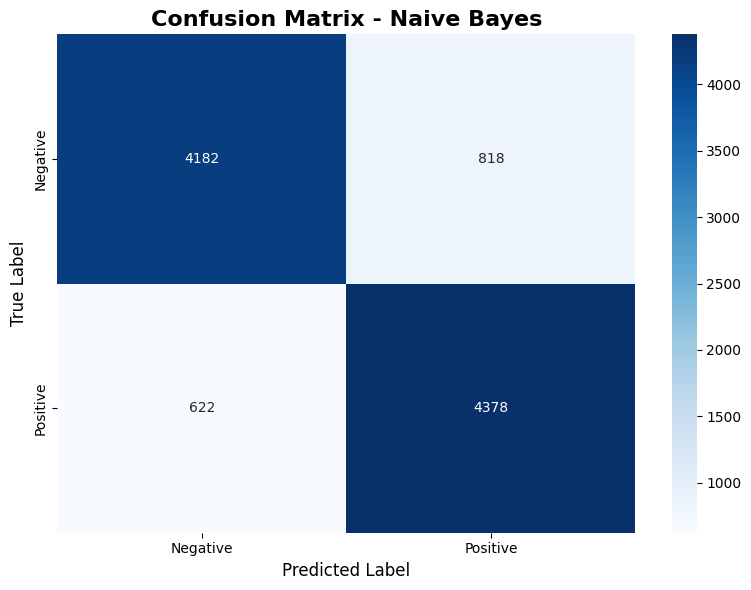

Confusion Matrix Values:
[[4182  818]
 [ 622 4378]]

 Logistic Regression Confusion Matrix


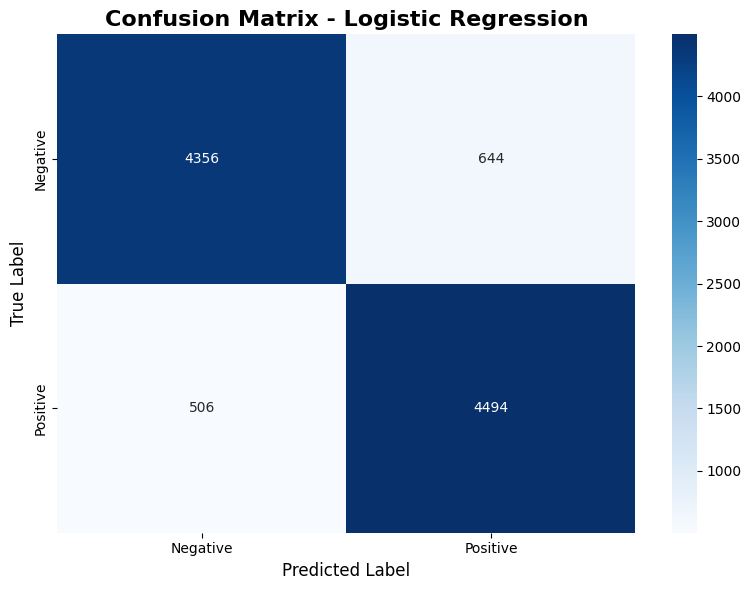

Confusion Matrix Values:
[[4356  644]
 [ 506 4494]]


In [12]:
# Confusion Matrix Visualization
print("\n" + "=" * 60)
print("STEP 6: CONFUSION MATRIX VISUALIZATION")
print("=" * 60)

# Creating confusion matrices for both models
for model_name, result in results.items():
    print(f"\n {model_name} Confusion Matrix")
    cm = analyzer.create_confusion_matrix(y_test, result['predictions'], model_name)
    print(f"Confusion Matrix Values:")
    print(cm)


STEP 7: MODEL COMPARISON AND FINAL RESULTS
 PERFORMANCE COMPARISON:
              Model Accuracy Precision Recall F1-Score
        Naive Bayes   0.8560    0.8426 0.8756   0.8588
Logistic Regression   0.8850    0.8747 0.8988   0.8866


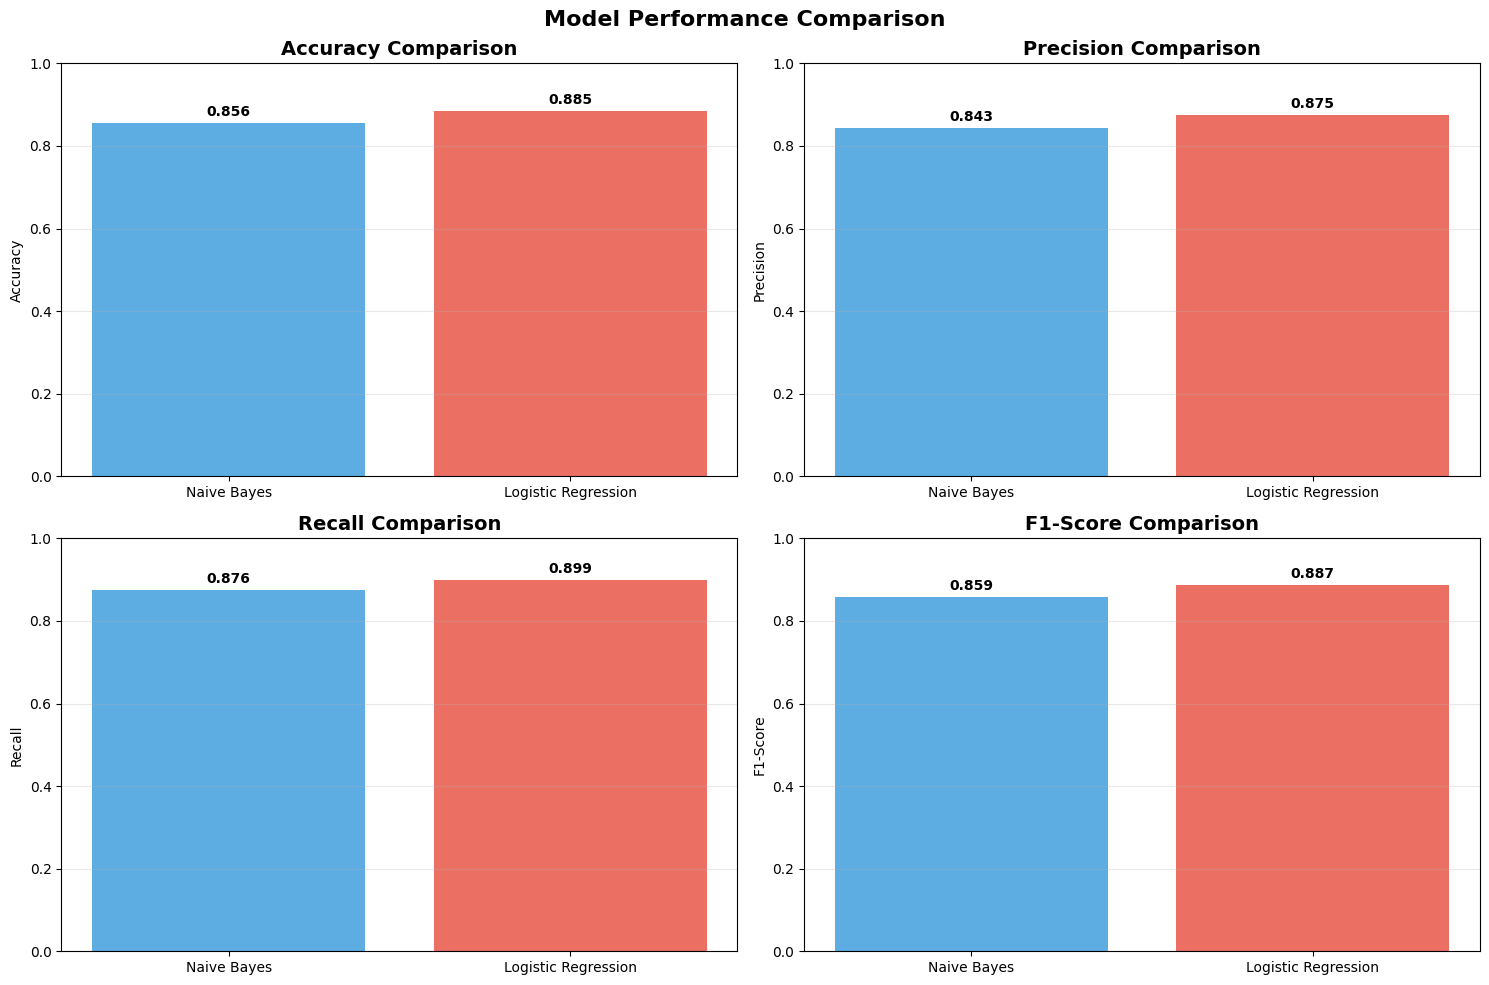

In [13]:
# Model Comparison and Results (CORRECTED)
print("\n" + "=" * 60)
print("STEP 7: MODEL COMPARISON AND FINAL RESULTS")
print("=" * 60)

# Create comparison table
comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'Precision': f"{metrics['precision']:.4f}",
        'Recall': f"{metrics['recall']:.4f}",
        'F1-Score': f"{metrics['f1_score']:.4f}"  # Fixed: was 'f1-score'
    })

comparison_df = pd.DataFrame(comparison_data)
print(" PERFORMANCE COMPARISON:")
print(comparison_df.to_string(index=False))

# Visual comparison - FIXED METRIC NAMES
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_keys = ['accuracy', 'precision', 'recall', 'f1_score']  # Correct keys

models = list(results.keys())

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (metric, metric_key) in enumerate(zip(metrics, metric_keys)):
    values = [results[model][metric_key] for model in models]  # Use correct key
    bars = axes[i].bar(models, values, color=['#3498db', '#e74c3c'], alpha=0.8)
    axes[i].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', alpha=0.3)
    
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
# Final Summary
print("\n" + "=" * 60)
print("STEP 8: FINAL SUMMARY")
print("=" * 60)

# Determine best model
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']

print(f" BEST PERFORMING MODEL: {best_model_name}")
print(f" Best Accuracy: {results[best_model_name]['accuracy']:.4f}")



STEP 8: FINAL SUMMARY
 BEST PERFORMING MODEL: Logistic Regression
 Best Accuracy: 0.8850
